In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("/home/mizworski/Repos/xgboost/python-package/")
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.utils.validation import column_or_1d
from scipy import interp

In [2]:
date_parse_format = '%Y-%m-%d'


def preprocess_data(data):
    categorical_cols = list(set(data.columns) - set(['birth_date', 'contact_date', 'pdays', 'campaign', 'y']))
    
    X = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
    X['contacted'] = pd.get_dummies(X.pdays < 999, drop_first=True)
    now = datetime.strptime(X.contact_date.max(), date_parse_format)
    X['age'] = X.apply(lambda r: int((now - datetime.strptime(r.birth_date, date_parse_format)).days / 365.25), axis=1)
    X.drop('birth_date', axis=1, inplace=True)
    X['days_since_contact'] =  X.apply(lambda r: int((now - datetime.strptime(r.contact_date, date_parse_format)).days), axis=1)
    X.drop('contact_date', axis=1, inplace=True)
    
    train_x = X[X.y != 'unknown']
    test_x = X[X.y == 'unknown']
    train_y = train_x['y']
    train_y = pd.get_dummies(train_y, drop_first=True)
    train_x = train_x.drop('y', axis=1)
    test_x = test_x.drop('y', axis=1)
    
#     train_y = column_or_1d(train_y)
#     train_x = train_x.as_matrix()
#     test_x = test_x.as_matrix()
    
    return train_x, train_y, test_x
    

In [3]:
df = pd.read_csv('../data/bank-classification.csv', index_col=0)
df = df.sample(frac=1)

In [4]:
model = XGBClassifier()
cv = StratifiedKFold(n_splits=6)

In [5]:
X_train, Y_train, X_test = preprocess_data(df)

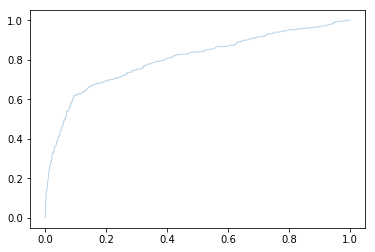

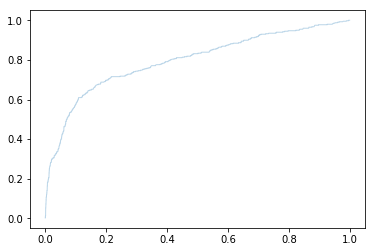

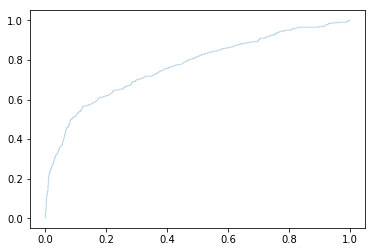

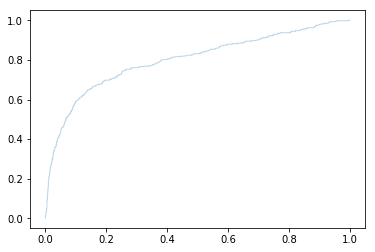

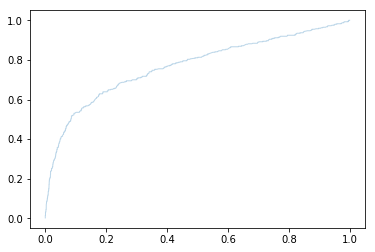

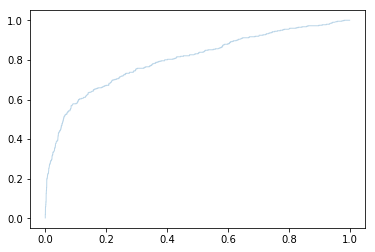

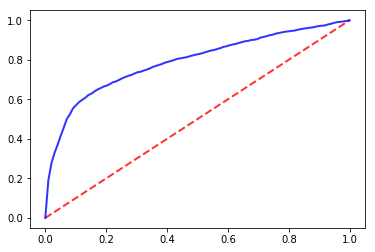

In [6]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i=0

X = X_train.as_matrix()
Y = column_or_1d(Y_train)
for train, test in cv.split(X, Y):
    probas_ = model.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    plt.show()

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.show()

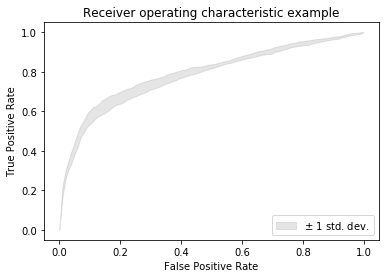

In [7]:
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [20]:
mean_auc

0.78956324556373514

In [8]:
full_model = XGBClassifier()
full_model.fit(X_train.as_matrix(), Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [9]:
y_pred = model.predict(X_test.as_matrix())
y_proba = model.predict_proba(X_test.as_matrix())

In [10]:
# pd.Series(y_pred).value_counts()

In [11]:
test_indices = X_test.index.values
test_indices

array([ 2747,  9916, 28860, ..., 30219, 25060, 39800])

In [12]:
y_pred[-15:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [13]:
y_proba[:, 1][-15:]

array([ 0.05655886,  0.37660676,  0.03343203,  0.0458167 ,  0.0601963 ,
        0.0332014 ,  0.10031843,  0.18599974,  0.04642965,  0.06297246,
        0.03415786,  0.05517633,  0.16295438,  0.06683259,  0.23675215], dtype=float32)

In [14]:
y_proba.shape

(20389, 2)

In [15]:
y_proba[:, 1].shape

(20389,)

In [16]:
results = pd.DataFrame({'id':test_indices, 'y':y_proba[:, 1]})

In [17]:
results.head()

,id,y
0,2747,0.033654
1,9916,0.041430
2,28860,0.114886
3,3389,0.034762
4,36250,0.344676


In [18]:
results_sorted = results.sort_values(['id'])

In [21]:
results_sorted.to_csv('test_submition.csv', index=False)